# 패키지 임포트

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 경로 설정 - 드라이브

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/2021 ICT 종합설계/이미지/train'
TEST_DATASET_PATH = '/content/drive/MyDrive/2021 ICT 종합설계/이미지/test'

# 이미지 증강

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # 일반화
    rotation_range=10, # 랜덤하게 이미지를 회전
    zoom_range=0.1, # 랜덤하게 이미지를 확대
    width_shift_range=0.1, # 랜덤하게 이미지를 수평으로 이동
    height_shift_range=0.1, # 랜덤하게 이미지를 수직으로 이동
    horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    TEST_DATASET_PATH,
    target_size=(224,224), # (height, width)
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size=(224,224), # (height, width)
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2100 images belonging to 7 classes.
Found 583 images belonging to 7 classes.


# 데이터 미리보기

In [5]:
from pprint import pprint
pprint(train_gen.class_indices)

{'매트리스': 0,
 '의자': 1,
 '침낭': 2,
 '코펠': 3,
 '테이블': 4,
 '텐트': 5,
 '화로': 6}


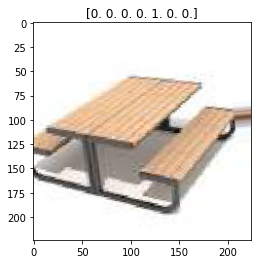

In [6]:
preview_batch = train_gen.__getitem__(0) # 0번 배치의 이미지를 가져와라

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0])) # 0번 이미지의 라벨
plt.imshow(preview_imgs[0])  # 0번 이미지

# ResNet50 모델 불러오기

In [7]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs= base_model.input, outputs= output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

# 학습시킨 모델 저장

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen, # 학습 데이터
    validation_data= test_gen, # 검증 데이터
    epochs=20, # 반복학습
    callbacks=[
               # 정확도가 가장 높은 모델을 파일로 저장
               ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
66/66 [==============================] - 1638s 25s/step - loss: 3.8976 - acc: 0.4667 - val_loss: 10.9670 - val_acc: 0.1647

Epoch 00001: val_acc improved from -inf to 0.16467, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
66/66 [==============================] - 1471s 22s/step - loss: 1.1897 - acc: 0.6190 - val_loss: 1.9613 - val_acc: 0.1389

Epoch 00002: val_acc did not improve from 0.16467
Epoch 3/20
66/66 [==============================] - 1467s 22s/step - loss: 0.7259 - acc: 0.7343 - val_loss: 1.9798 - val_acc: 0.1715

Epoch 00003: val_acc improved from 0.16467 to 0.17153, saving model to model.h5
Epoch 4/20
64/66 [============================>.] - ETA: 41s - loss: 0.5562 - acc: 0.8030 

KeyboardInterrupt: ignored

# 모델 불러와서 테스트하기

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model('model.h5') 

print('Model loaded!')

Model loaded!


test accuracy : 84.375 %


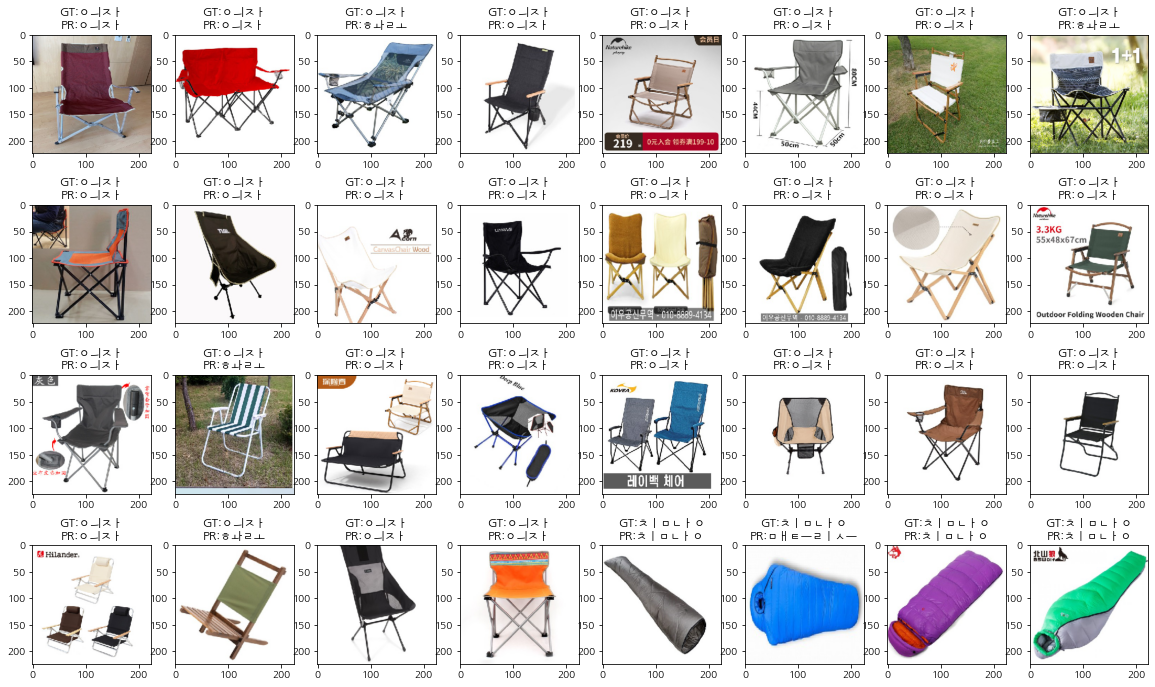

In [ ]:
# 테스트할 이미지세트. 숫자를 변경해가며 테스트
test_imgs, test_labels = test_gen.__getitem__(5)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

plt.rc('font', family='NanumGothic')
fig, axes = plt.subplots(4, 8, figsize=(20, 12))

correct_count = 0

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]
  if test_label == pred_label:
    correct_count += 1
  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)

test_accuracy = (correct_count / 32) * 100
print(f"test accuracy : {test_accuracy:.3f} %")

# Inception v3 모델 불러오기

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

# 학습시킨 모델 저장하기

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
  train_gen,
  validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
  epochs=20, # epochs 복수형으로 쓰기!
  callbacks=[
    ModelCheckpoint('inception_v3_model.h5', monitor='val_acc', verbose=1, save_best_only=True)
  ]
)

Epoch 1/20
66/66 [==============================] - 61s 778ms/step - loss: 1.2350 - acc: 0.6781 - val_loss: 1621.2225 - val_acc: 0.0961

Epoch 00001: val_acc improved from -inf to 0.09605, saving model to inception_v3_model.h5
Epoch 2/20
66/66 [==============================] - 47s 702ms/step - loss: 0.8008 - acc: 0.7552 - val_loss: 2.9533 - val_acc: 0.3602

Epoch 00002: val_acc improved from 0.09605 to 0.36021, saving model to inception_v3_model.h5
Epoch 3/20
66/66 [==============================] - 46s 700ms/step - loss: 0.7619 - acc: 0.7486 - val_loss: 2.3797 - val_acc: 0.3122

Epoch 00003: val_acc did not improve from 0.36021
Epoch 4/20
66/66 [==============================] - 46s 698ms/step - loss: 0.5320 - acc: 0.8295 - val_loss: 0.7616 - val_acc: 0.7393

Epoch 00004: val_acc improved from 0.36021 to 0.73928, saving model to inception_v3_model.h5
Epoch 5/20
66/66 [==============================] - 47s 701ms/step - loss: 0.4878 - acc: 0.8433 - val_loss: 1.1115 - val_acc: 0.6381

E

# 모델 불러와서 테스트

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model('inception_v3_model.h5') 

test accuracy : 96.875 %


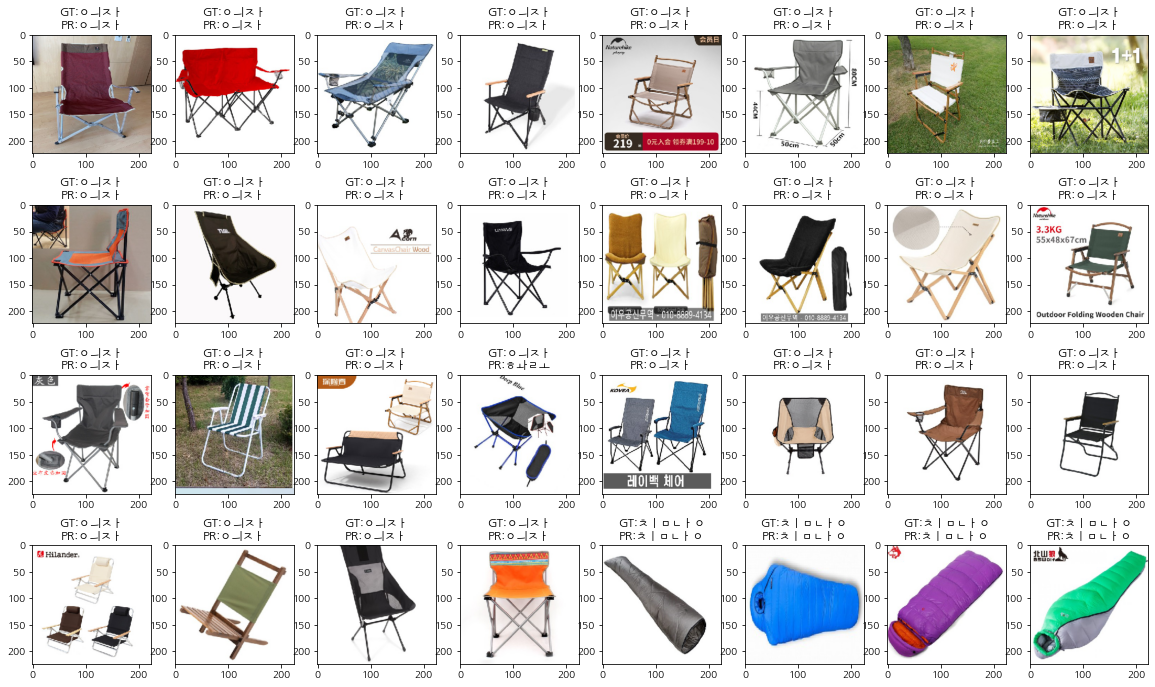

In [ ]:
# 테스트할 이미지세트. 숫자를 변경해가며 테스트
test_imgs, test_labels = test_gen.__getitem__(5)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

plt.rc('font', family='NanumGothic')
fig, axes = plt.subplots(4, 8, figsize=(20, 12))

correct_count = 0

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]
  if test_label == pred_label:
    correct_count += 1
  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)

test_accuracy = (correct_count / 32) * 100
print(f"test accuracy : {test_accuracy:.3f} %")

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arrange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c ='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.',  c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()